# 시계열 분석 연습문제

## 문제1

## #01. 작업준비

### 필요한 패키지 설치

In [55]:
import sys
sys.path.append("../../")

from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA 
from pmdarima.arima import auto_arima
import seaborn as sb

from helper import set_datetime_index, exp_time_data

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### 데이터 가져오기

In [56]:
df = read_excel("https://data.hossam.kr/E06/temperatures_seoul.xlsx")
df

,날짜,평균기온(℃)
0,1973-07-01,22.7
1,1973-07-02,23.8
2,1973-07-03,27.2
3,1973-07-04,25.2
4,1973-07-05,26.9
...,...,...
18294,2023-08-02,29.7
18295,2023-08-03,29.5
18296,2023-08-04,30.0
18297,2023-08-05,30.3


## #02. 데이터 정제

### 각 필드의 데이터타입 확인

In [57]:
df.dtypes

날짜         datetime64[ns]
평균기온(℃)           float64
dtype: object

### 결측치 검사

In [58]:
df.isna().sum()

날짜         0
평균기온(℃)    0
dtype: int64

### date 필드를 날짜 형식의 인덱스로 지정

In [59]:
df2 = set_datetime_index(df, '날짜')
df2

,평균기온(℃)
1973-07-01,22.7
1973-07-02,23.8
1973-07-03,27.2
1973-07-04,25.2
1973-07-05,26.9
...,...
2023-08-02,29.7
2023-08-03,29.5
2023-08-04,30.0
2023-08-05,30.3


## #03. 데이터 검정

In [60]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

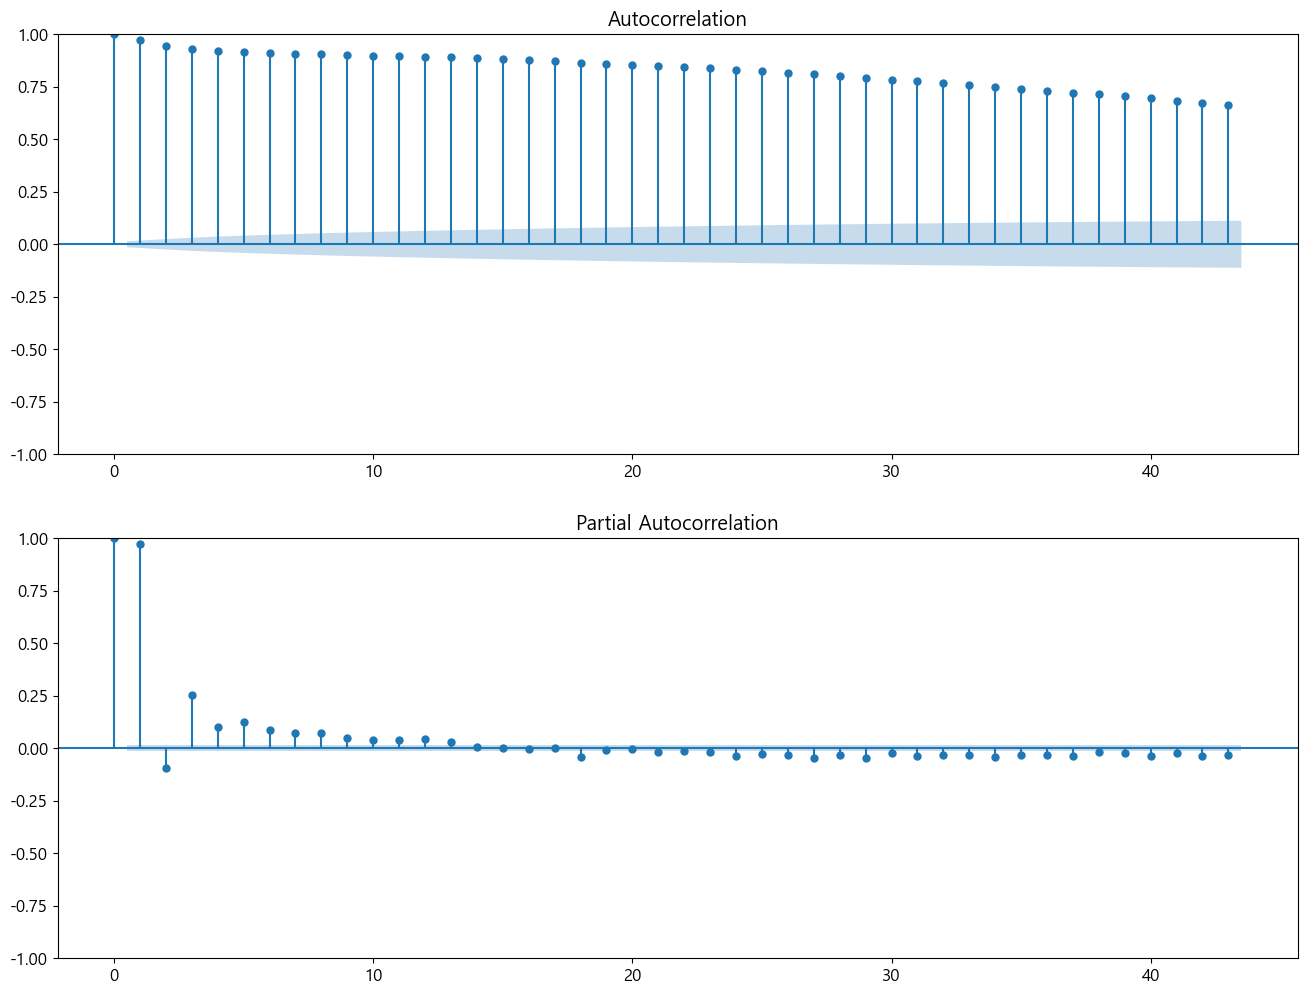

In [61]:
# ACF, PACF 확인
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,12))

plot_acf(df['평균기온(℃)'], ax=ax1)
plot_pacf(df['평균기온(℃)'], ax=ax2)
plt.show()
plt.close()

결측치 수 : 0


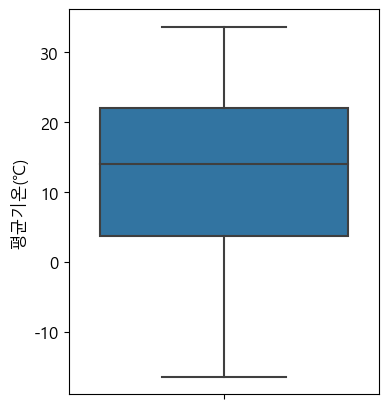

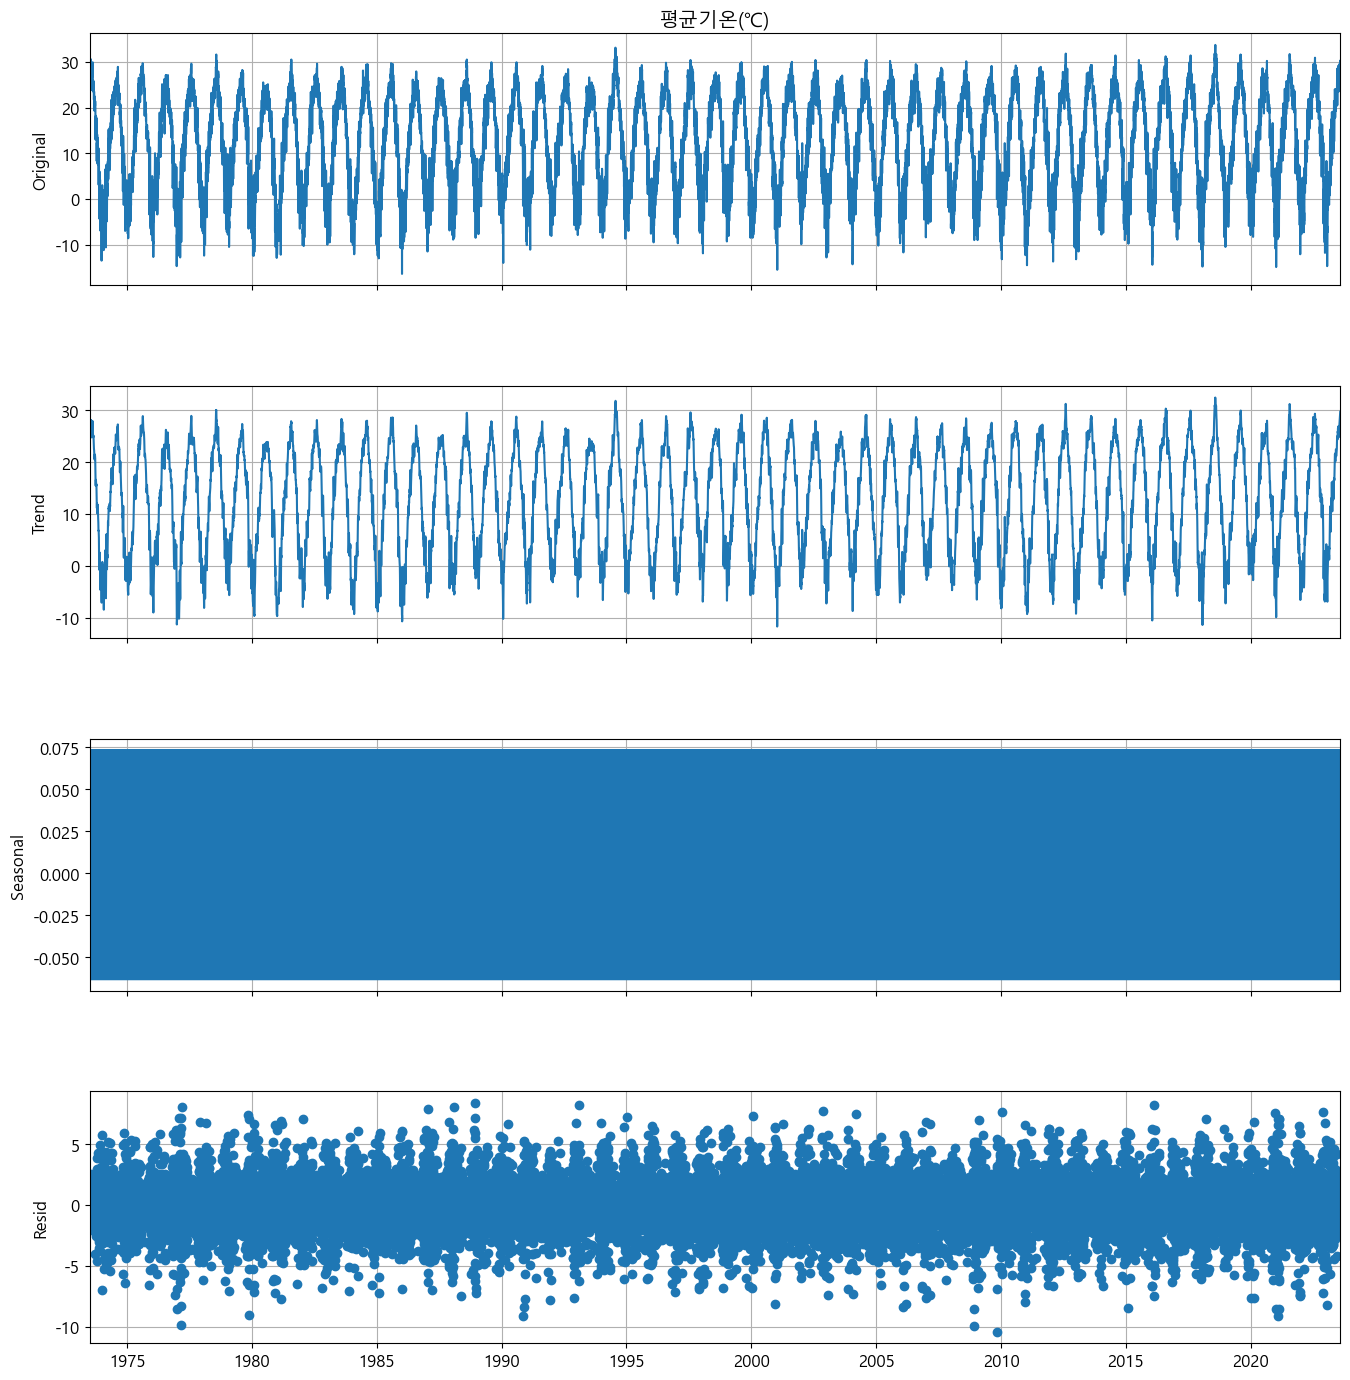

========= 원본 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -13.6504 |
| 유의수준(p-value)                  | 1.58975e-25 |
| 최적차수(num of lags)              |          45 |
| 관측치 개수(num of observations)   |       18253 |
| 기각값(Critical Values) 1%         |    -3.43071 |
| 기각값(Critical Values) 5%         |     -2.8617 |
| 기각값(Critical Values) 10%        |    -2.56685 |
| 데이터 정상성 여부(0=False,1=True) |           1 |
+------------------------------------+-------------+


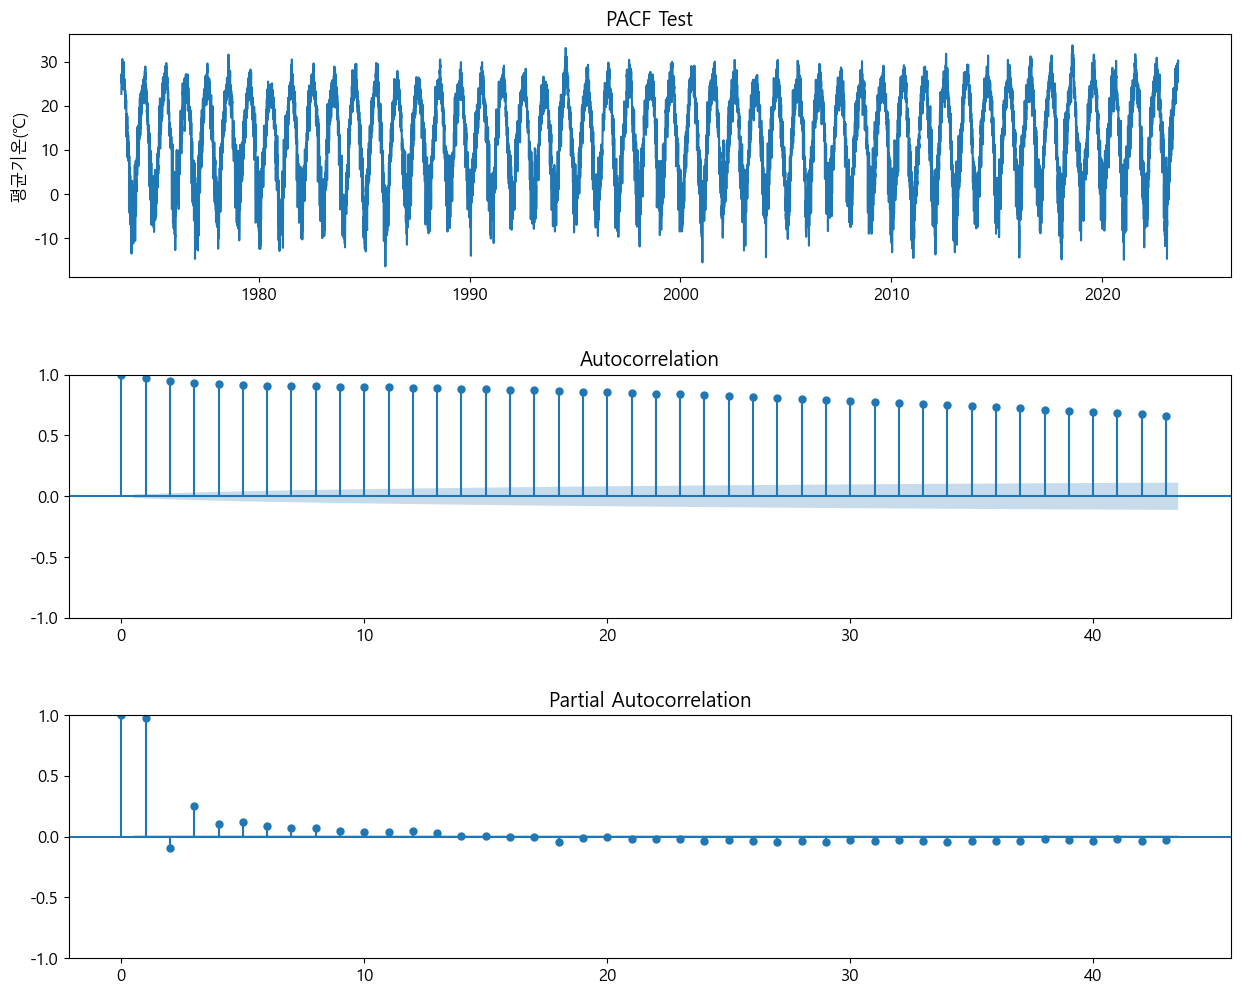

In [20]:
exp_time_data(data=df2, yname="평균기온(℃)", sd_model="a")

## #04. ARIMA 분석

### 분석모델 구축

In [83]:
model = ARIMA(df2['평균기온(℃)'], order=(4,0,0), seasonal_order=(2,0,0,12))
fit = model.fit()
print(fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                          평균기온(℃)   No. Observations:                18299
Model:             ARIMA(4, 0, 0)x(2, 0, 0, 12)   Log Likelihood              -40684.177
Date:                          Mon, 07 Aug 2023   AIC                          81384.353
Time:                                  15:05:03   BIC                          81446.870
Sample:                              07-01-1973   HQIC                         81404.895
                                   - 08-06-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6527      1.016     12.457      0.000      10.662      14.644
ar.L1          1.0644      0.006    165.762      0.

### 학습데이터에 대한 예측치

In [75]:
fv = fit.fittedvalues
fv.head()

1973-07-01    12.652694
1973-07-02    22.446493
1973-07-03    23.593984
1973-07-04    26.988589
1973-07-05    23.855816
Freq: D, dtype: float64

In [76]:
fc = fit.forecast(365)
fc.tail()

2024-08-01    12.774776
2024-08-02    12.773119
2024-08-03    12.771485
2024-08-04    12.769872
2024-08-05    12.768282
Freq: D, Name: predicted_mean, dtype: float64

### 시각화

In [81]:
last = df2.index.max()
xmin = last-timedelta(days=365)
xmax = last+timedelta(days=365+10)
ymax = df2['평균기온(℃)'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2022-08-06 00:00:00'), Timestamp('2024-08-15 00:00:00'), 30.3)

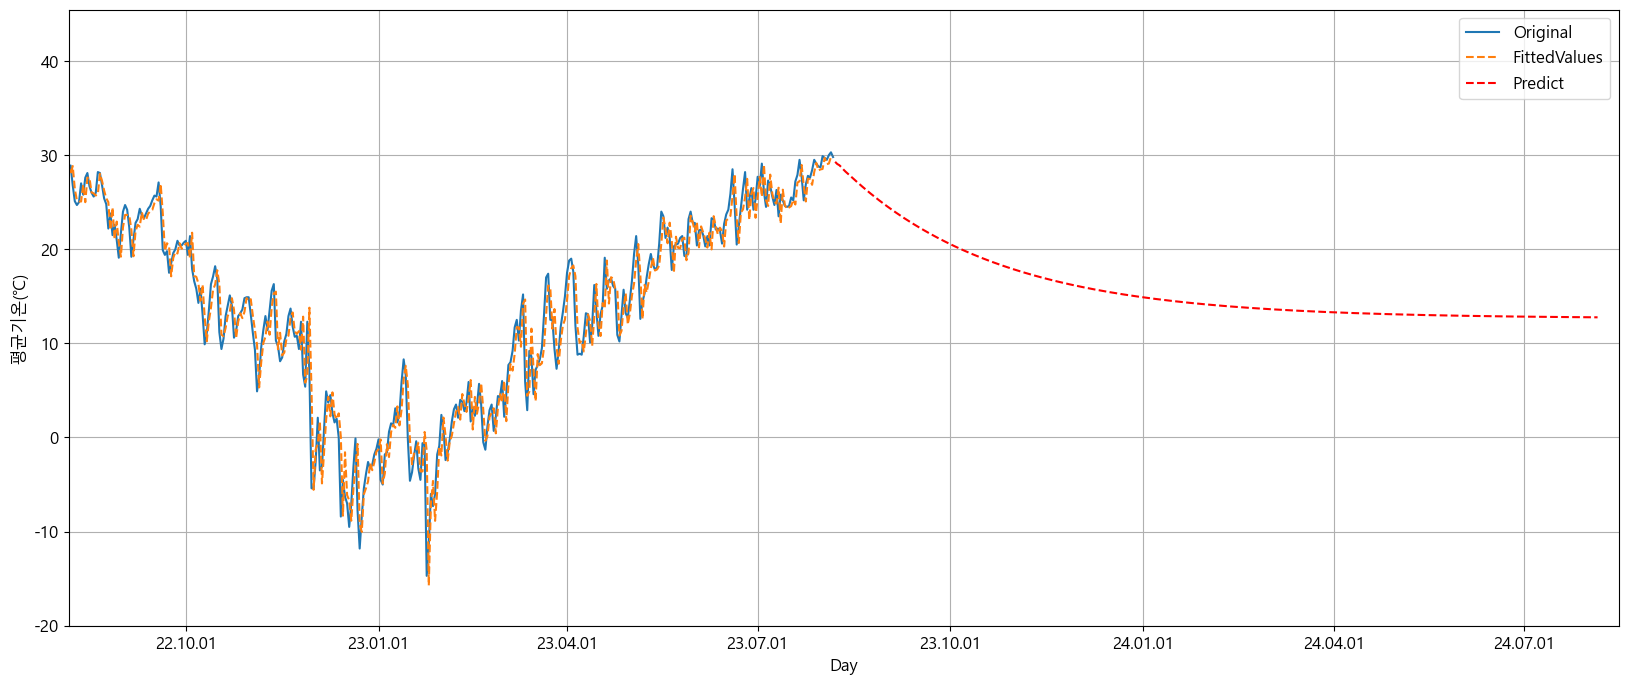

In [82]:
plt.figure(figsize=(20,8))

# 원본데이터
sb.lineplot(data=df2, x=df2.index, y='평균기온(℃)', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 향후 365일간의 예측값
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('평균기온(℃)')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([-20,ymax*1.5])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

### #04. AutoARIMA 분석

In [52]:
my_p = 1    # AR의 차수(검증한 결과를 활용)
my_d = 1    # 차분횟수(검증한 결과를 활용)
my_q = 0    # MA의 차수(검증한 결과를 활용)
my_s = 4    # 계절성 주기(분석가가 판단)

model = auto_arima(
    y=df2['평균기온(℃)'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,          # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=97143.193, Time=0.25 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=90787.948, Time=0.84 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=96675.126, Time=0.19 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=90992.763, Time=0.40 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=90789.948, Time=2.32 sec

Best model:  ARIMA(1,1,0)(1,1,0)[4]          
Total fit time: 4.008 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                18299
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 4)   Log Likelihood              -45390.974
Date:                           Mon, 07 Aug 2023   AIC                          90787.948
Time:                                   14:10:27   BIC                          90811.391
Sample:                               07-01-1973   HQIC                         90795.651
     

### 학습한 데이터와 동일 기간에 대한 예측치 산정

In [53]:
fv = model.fittedvalues()
fv

1973-07-01     0.000000
1973-07-02    22.700014
1973-07-03    23.800002
1973-07-04    27.199997
1973-07-05    36.549995
                ...    
2023-08-02    30.161578
2023-08-03    29.401091
2023-08-04    29.878964
2023-08-05    31.160759
2023-08-06    29.904508
Freq: D, Length: 18299, dtype: float64

### 향후 365일간의 예측

In [54]:
fc = model.predict(n_periods=365)
fc

2023-08-07    29.526623
2023-08-08    29.708468
2023-08-09    30.482159
2023-08-10    30.140109
2023-08-11    29.905369
                ...    
2024-08-01    52.761689
2024-08-02    53.053279
2024-08-03    53.663574
2024-08-04    53.267040
2024-08-05    53.018972
Freq: D, Length: 365, dtype: float64

### 시각화